In [7]:
!pip install torchinfo
!pip install timm

In [33]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

# Swin Transformer implementation from scratch

[Paper link](https://arxiv.org/abs/2103.14030)

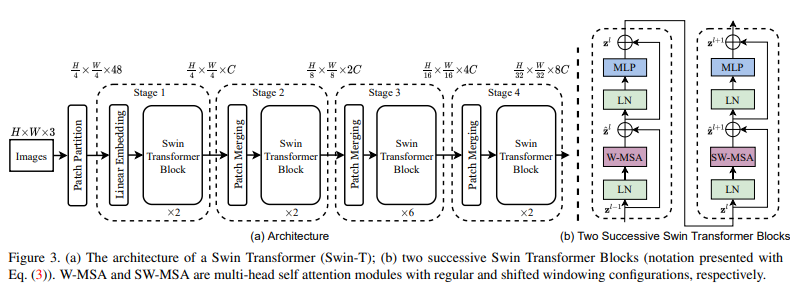

In [34]:
class MLP(nn.Module):
  def __init__(self, in_features, hidden_features = None, out_features = None, activation = nn.GELU, dropout = 0.):
    super().__init__()
    hidden_features = hidden_features or in_features
    out_features = out_features or in_features
    self.fc1 = nn.Linear(in_features, hidden_features)
    self.act = activation()
    self.fc2 = nn.Linear(hidden_features, out_features)
    self.drop = nn.Dropout(dropout)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act(x)
    x = self.drop(x)
    x = self.fc2(x)
    out = self.drop(x)

    return out

class PatchEmbed(nn.Module):
  """Patch Partition + Linear Embedding"""
  def __init__(self, img_size = 224, patch_size = 4, in_channels = 3, embed_dim = 96, norm_layer = None):
    super().__init__()

    img_size = to_2tuple(img_size)
    patch_size = to_2tuple(patch_size)
    patches_resolution = [img_size[0]//patch_size[0], img_size[1]//patch_size[1]]

    self.img_size = img_size
    self.patch_size = patch_size
    self.patches_resolution = patches_resolution
    self.num_patches = patches_resolution[0] * patches_resolution[1]
    self.in_channels = in_channels
    self.embed_dim = embed_dim
    self.partition = nn.Conv2d(in_channels, embed_dim, patch_size, padding = 0, stride = patch_size)
    if norm_layer is not None:
      self.norm = norm_layer(embed_dim)
    else:
      self.norm = None

  def forward(self, x):
    B, C, H, W = x.shape
    if H != self.img_size[0] or W != self.img_size[1]:
      raise ValueError(f"Input size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")
    out = self.partition(x).view(B, -1, C).transpose(1, 2)
    if self.norm is not None:
      out = self.norm(out)

    return out

  def flops(self):
    flops = self.patches_resolution[0] * self.patches_resolution[1] * self.in_channels * self.embed_dim * self.patch_size[0] * self.patch_size[1]
    if self.norm is not None:
      flops += self.embed_dim * self.patches_resolution[0] * self.patches_resolution[1]
    return flops

In [35]:
class PatchMerging(nn.Module):
    """
    Args:
        input_resolution : Resolution of input feature.
        dim : Number of input channels.
    """

    def __init__(self, input_resolution, dim, norm_layer = nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.merge = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        if L != H * W:
          raise ValueError("Input feature has wrong size.")

        if H % 2 != 0 or W % 2 != 0:
          raise ValueError(f"x size ({H}*{W}) is not even.")


        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.merge(x)

        return x

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops

In [36]:
def window_partition(x, window_size):
  """ (B, H, W, C) -> (num_windows*B, window_size, window_size, C) """
  B, H, W, C = x.shape
  x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
  windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)

  return windows

def window_reverse(windows, window_size, H, W):
    """ (num_windows*B, window_size, window_size, C) -> (B, H, W, C) """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)

    return x

In [37]:
class MSA(nn.Module):
    """ Window based multi-head self attention module with relative position bias, supporting both of shifted and non-shifted window """

    def __init__(self, dim, window_size, num_heads, qkv_bias = True, qk_scale = None, attn_drop = 0., proj_drop = 0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # Parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH
        trunc_normal_(self.relative_position_bias_table, std = .02)

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn += relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops

In [38]:
class SwinTransformerBlock(nn.Module):
    """ Swin Transformer Block.

    Args:
        shift_size : Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size = 7, shift_size = 0, mlp_ratio = 4., qkv_bias = True, qk_scale = None, drop = 0., attn_drop = 0., drop_path = 0.,
                 act_layer = nn.GELU, norm_layer = nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, do not partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)

        if not (0 <= self.shift_size < self.window_size):
          raise ValueError("shift_size must be in the range 0 to window_size.")

        self.norm1 = norm_layer(dim)
        self.attn = MSA(dim, window_size = to_2tuple(self.window_size), num_heads = num_heads,
            qkv_bias = qkv_bias, qk_scale = qk_scale, attn_drop = attn_drop, proj_drop = drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features = dim, hidden_features = mlp_hidden_dim, activation = act_layer, dropout = drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        if L != H * W:
          raise ValueError("Input feature has wrong size")

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        else:
            shifted_x = x
            x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C

        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)

        # reverse cyclic shift
        if self.shift_size > 0:
            shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
            x = shifted_x
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(x)

        # FFN
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops

In [39]:
class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio = 4., qkv_bias = True, qk_scale = None, drop=0., attn_drop = 0.,
                 drop_path = 0., norm_layer = nn.LayerNorm, downsample = None):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution = input_resolution,
                                 num_heads = num_heads, window_size = window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio = mlp_ratio,
                                 qkv_bias = qkv_bias, qk_scale = qk_scale,
                                 drop = drop, attn_drop = attn_drop,
                                 drop_path = drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim = dim, norm_layer = norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

In [40]:
class SwinTransformer(nn.Module):
    """ Swin Transformer
    Args:
        depths : Depth of each Swin Transformer layer.
        num_heads : Number of attention heads in different layers.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
    """

    def __init__(self, img_size = 224, patch_size = 4, in_chans = 3, num_classes = 1000,
                 embed_dim = 96, depths = [2, 2, 6, 2], num_heads = [3, 6, 12, 24],
                 window_size = 7, mlp_ratio = 4., qkv_bias = True, qk_scale = None,
                 drop_rate = 0., attn_drop_rate = 0., drop_path_rate = 0.1,
                 norm_layer = nn.LayerNorm, ape = False, patch_norm = True, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size = img_size, patch_size = patch_size, in_channels = in_chans, embed_dim = embed_dim,
            norm_layer = norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim = int(embed_dim * 2 ** i_layer),
                               input_resolution = (patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth = depths[i_layer],
                               num_heads = num_heads[i_layer],
                               window_size = window_size,
                               mlp_ratio = self.mlp_ratio,
                               qkv_bias = qkv_bias, qk_scale = qk_scale,
                               drop = drop_rate, attn_drop = attn_drop_rate,
                               drop_path = dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer = norm_layer,
                               downsample = PatchMerging if (i_layer < self.num_layers - 1) else None)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

In [41]:
from torchinfo import summary

SwinTransformer = SwinTransformer()
dummy_input = torch.randn(1, 3, 224, 224)
dummy_output = SwinTransformer(dummy_input)

RuntimeError: ignored

# CIFAR-100 Dataset

In [47]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

In [46]:
# Load CIFAR-100
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform)
loader_train = DataLoader(trainset, batch_size=32,
                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform)
loader_val = DataLoader(testset, batch_size=32,
                        shuffle=False, num_workers=2)


100%|██████████| 169001437/169001437 [00:04<00:00, 38946247.81it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [48]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [49]:
model = SwinTransformer(img_size = 32, patch_size = 4, in_chans = 3, num_classes = 100)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Setting device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

# Number of times you print updates
print_every = 100

def train(model, optimizer, epochs=1):

    model = model.to(device=device)
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(loader_val, model)
                print()

TypeError: ignored

In [ ]:
train(model, optimizer, epochs=50)